In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

<Axes: >

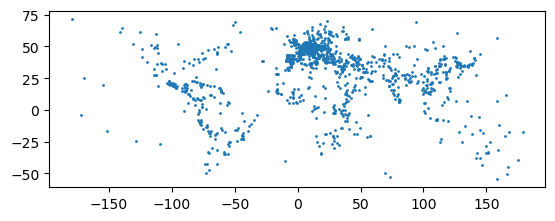

In [2]:
# Catálogo de datos
path_catalog = "../../Bases_de_datos/Data_catalog.csv"
df_c = pd.read_csv(path_catalog)

# World Heritage List
id = "WHC"

# Cargamos el archivo
df = pd.read_excel( "../../" + df_c.loc[df_c["ID"]==id, "Path"].iloc[0]
    + df_c.loc[df_c["ID"]==id, "Filename" ].iloc[0], index_col = "id_no"
    ).sort_index()
# Creamos un punto con las coordenadas.
df["geometry"] = gpd.points_from_xy(df["longitude"], df["latitude"])
# Creamos un GeoDataFrame.
df = gpd.GeoDataFrame(df, geometry = "geometry", crs = 4326)

df.plot( markersize = 1 )

In [30]:
c_path = "../share/Climate/"
c_files = os.listdir(c_path)

categories = [ "Drought", "Extreme_temperature",
    "Extreme_rainfall", "Hurricane" ]
cat_var   = []
cat_col_h = []
cat_col_f = []

for cat in categories:
    ds_h = xr.open_dataset(c_path + f"{cat}_1995_2014.nc")
    ds_f = xr.open_dataset(c_path + f"{cat}_2040_2059_SSP245.nc")
    vars = list(ds_h.variables)
    vars.remove("lat")
    vars.remove("lon")
    cat_var.append(vars)

    cols_h = ( [ f"{vars[0]}, 1995-2014, historical" ]
        + [ f"{cat.replace("_", " ")} {x}, 1995-2014, historical"
        for x in vars[1:] ] )
    cols_f = ( [ f"{vars[0]}, 2040-2059, SSP2-4.5" ]
        + [ f"{cat.replace("_", " ")} {x}, 2040-2059, SSP2-4.5"
        for x in vars[1:] ] )
    df[cols_h] = None
    df[cols_f] = None
    cat_col_h.append(cols_h)
    cat_col_f.append(cols_f)

    for row in df.itertuples():
        vals_h = ds_h.sel( lat = row.latitude,
            lon = row.longitude, method = "nearest" )
        vals_f = ds_f.sel( lat = row.latitude,
            lon = row.longitude, method = "nearest" )
        for i in range(0, len(cols_h)):
            if i == 1:
                df.loc[row.Index, cols_h[i]] = bool(vals_h[vars[i]].values + 0)
                df.loc[row.Index, cols_f[i]] = bool(vals_f[vars[i]].values + 0)
            else:
                df.loc[row.Index, cols_h[i]] = vals_h[vars[i]].values + 0
                df.loc[row.Index, cols_f[i]] = vals_f[vars[i]].values + 0

In [123]:
name = "culturales"
v = "Cultural"

columns = [ "name_en", "states_name_en", "category", "danger" ]
sites = df.loc[ df["category"].isin([v]) &
        ( ( df[cat_col_f[1][1]] & ~df[cat_col_h[1][1]] )
        | ( df[cat_col_f[2][1]] & ~df[cat_col_h[2][1]] )
        | ( df[cat_col_f[3][1]] & ~df[cat_col_h[3][1]] ) ),
        columns + [ cat_col_f[1][1],
        cat_col_f[2][1], cat_col_f[3][1] ] ]
sites["count"] = sites.iloc[:, -3:].sum(axis = 1)

print(f"Zonas {name} en riesgo climático: {sites.shape[0]}")
n = df.loc[ df["category"].isin([v]) ].shape[0]
print(f"Total de zonas {name}: {n}")
n2 = 100 * sites.shape[0] / n
print(f"% de zonas {name} en riesgo climático: {n2:.1f}%")
n3 = df.loc[ df["category"].isin([v]) & df["danger"].isin([1]) ].shape[0]
print(f"Zonas {name} amenazadas: {n3}")
if n3 > 0:
    n4 = sites[ sites["danger"].isin([1]) ].shape[0]
    print(f"Zonas {name} amenazadas y en riesgo climático: {n4}")
    n5 = 100 * n4 / n3
    print(f"% de zonas {name} amenazadas en riesgo climático: {n5:.1f}%")

sites.sort_values( ["danger", "count"], ascending = False).head(14)

Zonas culturales en riesgo climático: 65
Total de zonas culturales: 933
% de zonas culturales en riesgo climático: 7.0%
Zonas culturales amenazadas: 40
Zonas culturales amenazadas y en riesgo climático: 3
% de zonas culturales amenazadas y en riesgo climático: 7.5%


,name_en,states_name_en,category,danger,"Extreme temperature Hotspots, 2040-2059, SSP2-4.5","Extreme rainfall Hotspots, 2040-2059, SSP2-4.5","Hurricane Hotspots, 2040-2059, SSP2-4.5",count
id_no,,,,,,,,
21,Ancient City of Aleppo,Syrian Arab Republic,Cultural,1,True,False,False,1
23,Site of Palmyra,Syrian Arab Republic,Cultural,1,True,False,False,1
1348,Ancient Villages of Northern Syria,Syrian Arab Republic,Cultural,1,True,False,False,1
714,Rock Paintings of the Sierra de San Francisco,Mexico,Cultural,0,True,True,True,3
86,Memphis and its Necropolis – the Pyramid Field...,Egypt,Cultural,0,True,True,False,2
89,Historic Cairo,Egypt,Cultural,0,True,True,False,2
278,Babylon,Iraq,Cultural,0,True,True,False,2
1107,Incense Route - Desert Cities in the Negev,Israel,Cultural,0,True,True,False,2
1192,Qal’at al-Bahrain – Ancient Harbour and Capita...,Bahrain,Cultural,0,True,True,False,2


In [121]:
name = "mixtas"
v = "Mixed"

columns = [ "name_en", "states_name_en", "category", "danger" ]
sites = df.loc[ df["category"].isin([v]) &
        ( ( df[cat_col_f[1][1]] & ~df[cat_col_h[1][1]] )
        | ( df[cat_col_f[2][1]] & ~df[cat_col_h[2][1]] )
        | ( df[cat_col_f[3][1]] & ~df[cat_col_h[3][1]] ) ),
        columns + [ cat_col_f[1][1],
        cat_col_f[2][1], cat_col_f[3][1] ] ]
sites["count"] = sites.iloc[:, -3:].sum(axis = 1)

print(f"Zonas {name} en riesgo climático: {sites.shape[0]}")
n = df.loc[ df["category"].isin([v]) ].shape[0]
print(f"Total de zonas {name}: {n}")
n2 = 100 * sites.shape[0] / n
print(f"% de zonas {name} en riesgo climático: {n2:.1f}%")
n3 = df.loc[ df["category"].isin([v]) & df["danger"].isin([1]) ].shape[0]
print(f"Zonas {name} amenazadas: {n3}")
if n3 > 0:
    n4 = sites[ sites["danger"].isin([1]) ].shape[0]
    print(f"Zonas {name} amenazadas y en riesgo climático: {n4}")
    n5 = 100 * n4 / n3
    print(f"% de zonas {name} amenazadas en riesgo climático: {n5:.1f}%")

sites.sort_values( ["danger", "count"], ascending = False).head(3)

Zonas mixtas en riesgo climático: 3
Total de zonas mixtas: 39
% de zonas mixtas en riesgo climático: 7.7%
Zonas mixtas amenazadas: 0


,name_en,states_name_en,category,danger,"Extreme temperature Hotspots, 2040-2059, SSP2-4.5","Extreme rainfall Hotspots, 2040-2059, SSP2-4.5","Hurricane Hotspots, 2040-2059, SSP2-4.5",count
id_no,,,,,,,,
64,Tikal National Park,Guatemala,Mixed,0,True,False,False,1
911,Mount Wuyi,China,Mixed,0,False,False,True,1
1061,Ancient Maya City and Protected Tropical Fores...,Mexico,Mixed,0,True,False,False,1


In [129]:
name = "naturales"
v = "Natural"

columns = [ "name_en", "states_name_en", "category", "danger" ]
sites = df.loc[ df["category"].isin([v]) &
        ( ( df[cat_col_f[1][1]] & ~df[cat_col_h[1][1]] )
        | ( df[cat_col_f[2][1]] & ~df[cat_col_h[2][1]] )
        | ( df[cat_col_f[3][1]] & ~df[cat_col_h[3][1]] ) ),
        columns + [ cat_col_f[1][1],
        cat_col_f[2][1], cat_col_f[3][1] ] ]
sites["count"] = sites.iloc[:, -3:].sum(axis = 1)

print(f"Zonas {name} en riesgo climático: {sites.shape[0]}")
n = df.loc[ df["category"].isin([v]) ].shape[0]
print(f"Total de zonas {name}: {n}")
n2 = 100 * sites.shape[0] / n
print(f"% de zonas {name} en riesgo climático: {n2:.1f}%")
n3 = df.loc[ df["category"].isin([v]) & df["danger"].isin([1]) ].shape[0]
print(f"Zonas {name} amenazadas: {n3}")
if n3 > 0:
    n4 = sites[ sites["danger"].isin([1]) ].shape[0]
    print(f"Zonas {name} amenazadas y en riesgo climático: {n4}")
    n5 = 100 * n4 / n3
    print(f"% de zonas {name} amenazadas en riesgo climático: {n5:.1f}%")

sites.sort_values( ["danger", "count"], ascending = False).head(5)

Zonas naturales en riesgo climático: 11
Total de zonas naturales: 227
% de zonas naturales en riesgo climático: 4.8%
Zonas naturales amenazadas: 16
Zonas naturales amenazadas y en riesgo climático: 2
% de zonas naturales amenazadas y en riesgo climático: 12.5%


,name_en,states_name_en,category,danger,"Extreme temperature Hotspots, 2040-2059, SSP2-4.5","Extreme rainfall Hotspots, 2040-2059, SSP2-4.5","Hurricane Hotspots, 2040-2059, SSP2-4.5",count
id_no,,,,,,,,
1182,Islands and Protected Areas of the Gulf of Cal...,Mexico,Natural,1,False,True,True,2
76,Everglades National Park,United States of America,Natural,1,False,False,True,1
554,Whale Sanctuary of El Vizcaino,Mexico,Natural,0,False,True,True,2
578,"Shark Bay, Western Australia",Australia,Natural,0,False,True,True,2
1186,Wadi Al-Hitan (Whale Valley),Egypt,Natural,0,True,True,False,2
